# Reinforcement Learning

1. **RL Intro**
2. Dynamic Programing
3. Tabular Q-Learning
4. Deep Reinforcement Learning (DQN)

## 1. RL Intro

In this first part we will recap some basics from the Reinforcement Learning literature. Namely, we will examine a simple **Markov Decision Process (MDP)** in the form of a gridworld environment, its observations, actions, rewards etc. and how to use them in order to build an intelligent RL agent.

## Prerequisites

- We install the **[pycolab](https://github.com/deepmind/pycolab)** engine and the **[exitgames](https://gitlab.mi.hdm-stuttgart.de/theodoridis/gridworlds)** gridworlds. The `pip -e` option will simply **link** the folders so python can find them. Just place them somewhere convenient in your system, e.g. next to your notebooks.

```
git clone https://github.com/deepmind/pycolab.git
pip install -e pycolab

git clone https://gitlab.mi.hdm-stuttgart.de/theodoridis/gridworlds.git
pip install -e gridworlds
```

- WINDOWS ONLY: `pycolab` requires the `curses` package which is not available by default. To install a compatible binary, [download the corresponding version from here](https://www.lfd.uci.edu/~gohlke/pythonlibs/#curses). For instance, choose **"curses‑2.2+utf8‑cp36‑cp36m‑win_amd64.whl"** for python 3.6 on a 64 bit system. Then install with:

```
pip install curses‑2.2+utf8‑cp36‑cp36m‑win_amd64.whl
```

Now, the best way to start is simply to:

### Play the game

> Note: In order to play, you must focus the pygame window! To play again, just restart the cell!

In [1]:
#clone and install game engine
!git clone https://github.com/deepmind/pycolab.git
!pip install -e pycolab

Cloning into 'pycolab'...


Obtaining file:///C:/johannes/hdm/1.%20Semester/pia/pia5/pycolab
  Running setup.py develop for pycolab


You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
#clone and install environment
!git clone https://gitlab.mi.hdm-stuttgart.de/theodoridis/gridworlds.git
!pip install -e gridworlds

Cloning into 'gridworlds'...


Obtaining file:///C:/johannes/hdm/1.%20Semester/pia/pia5/gridworlds
  Running setup.py develop for gridworlds


You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [16]:
#install curses
!pip install curses-2.2-cp36-cp36m-win_amd64.whl

Processing c:\johannes\hdm\1. semester\pia\pia5\curses-2.2-cp36-cp36m-win_amd64.whl


You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
from gridworlds import exitgames

# Goal: Find the exit and avoid the traps
# Actions: Arrow Keys to move, q to quit
# Style Options: "COLOR", "ASCII", "ALL" (will render both)

exitgames.play_notebook(level=0, style="COLOR")

Great! You finished the game in 0:0:19 with a score of 1.


Amount of **reward** for 
- moving around: 0
- moving on a trap: -1
- getting to the exit: +1

Spaces:
- the **state space**  (how many different states are possible): 16
- the **action space** (doing "nothing" is considered as NOOP action):up, down, left ,right, nohing --> 5


### Build a random agent

Now lets get familiar how an **agent** can play the game in an **agent-environment loop**. This is what we will build:

<img src="./AgentEnvLoop.png" alt="Agent-Environment-Loop" style="width: 400px;"/>

Since our first agent will simply pick actions at random (ignoring any inputs), the main task here is to learn about the exitgame interface and how to use it.

> In general, the agent will select actions based on the last state it has received. The Environment will then execute the action and emit the resulting reward and next state. Our ultimate goal is to build an agent that is able to **learn** from these $ ( S_t, A_t, R_{t+1}, S_{t+1})$ tuples. Over time, the agent should then select *better* actions leading to more reward in total.

###### Environment
- First, initialize the environment (the game). 

In [15]:
# create a new game
game = exitgames.make_game(level=0)

# initialize the game, this will return an observation, the first reward and 
# some additional information (_) which you can ignore by now.
observation, reward, _ = game.its_showtime()

###### Observations
- Now, we investigate how state is represented.

The **observation** object is holding two things:
1. The full game board, encoded as ASCII code integers: `observation.board`
2. A layer wise representation of all game objects, encoded as boolean maps: `observation.layers`

The **game board** is all we need since it encodes all information at once! However, the boolean maps can be handy in some cases so have a quick look at both!

In [16]:
print(observation.board)
print(observation.layers)

[[ 35  35  35  35  35  35]
 [ 35  32  32  32  69  35]
 [ 35  32 120  32  32  35]
 [ 35  32  32 120  32  35]
 [ 35  80  32  32  32  35]
 [ 35  35  35  35  35  35]]
{'x': array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False,  True, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]]), 'E': array([[False, False, False, False, False, False],
       [False, False, False, False,  True, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]]), ' ': array([[False, False, False, False, False, False],
       [False,  True,  True,  True, False, False],
       [False,  True, False,  True,  True, False],
       [False,  True,  True, False,  True, False],
 

In [17]:
# we can get a more human friendly "rendering" of the board by
# printing the ASCII codes of the board as actual characters. For starters, simply use the notebook_ui utility.
ui = exitgames.get_notebook_ui()

# Style Options: "COLOR", "ASCII", "ALL" (will render both)
ui.render(observation.board, "ASCII")

###### Actions
Great, now that we have seen how state is (and can be) represented, lets see how an agent can play the game by performing actual actions. But before acting in the environment:

- We have a look at the possible actions:

In [18]:
print("ActionSpace:", game.action_space)
print("ActionSet:", game.get_action_set())
print("ActionMeanings:", game.print_action_meanings())

ActionSpace: 5
ActionSet: {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1), 4: (0, 0)}
{0: 'NORTH', 1: 'SOUTH', 2: 'WEST', 3: 'EAST', 4: 'STAY'}
ActionMeanings: None


##### Steps

- Next, we perform an action and retrieve a new `observation, reward, _` triplet.
- To do so, we use the `game.play()` method which takes an **action key** integer (0,1,2,3,4) as argument and returns the next triplet.

- We play one (or more) actions, print the reward and render the resulting observation.
- If our output is not showing correctly, we make sure to put the "render" call last as it will trigger the notebook cell to repaint.
- If we reached the exit, we read the next notebook cell.

In [19]:
observation, reward, _ = game.play(0)
print(reward)

observation, reward, _ = game.play(0)
print(reward)

observation, reward, _ = game.play(0)
print(reward)

observation, reward, _ = game.play(3)
print(reward)

observation, reward, _ = game.play(3)
print(reward)

observation, reward, _ = game.play(3)
print(reward)

ui.render(observation.board, "ASCII")

None
None
None
None
None
1


Great, we are almost there. Before we start implementing the full agent-evironment loop and a basic random agent, here is some additional but important stuff to consider:

###### Episodes
- Exitgames are played in **episodes**, formally they are episodic MDPs. 
- If we reach a **terminal state** (the exit), the **episode** is over and calling `play()` will crash. If we want, we try it if it didnt happened already. 
- We can *reset* the game to play a new episode simply by creating a new game with `exitgames.make_game()`. We can detect when the game is over by checking `game.game_over`.

###### Return
- In Reinforcement Learning, the canonical goal of the agent is to collect **as much reward as possible per episode**. This is called **cumulative reward** or just **return**. To see how good or bad our agent performs per episode, we make sure we summarize all rewards per episode and report the total return at the end of each episode.


- We noticed that the reward is `None` and not `0` if there was emitted "no reward" by the environment. Nothing special about this, we just include a type check before we add a reward to our return. This is a pycolab (the engine behind exitgames) specific implementation detail.


### Now really, build a random agent

Steps:

##### Initial setup
1. Create a new game
2. Create a placeholder for the return
2. Initialize the game and receive the first triplet, e.g: `observation, reward, _` 
3. Add the first reward to the return

##### Now loop `while not game.game_over:`
1. Select a random action e.g. with `numpy.random` and `game.action_space`
2. Apply the action and receive the next `observation, reward, _` triplet.
3. Add the reward to the return
4. After the episode has terminated, we print the total return.

##### Rendering
If we want to see your agent play, we just include a render call in the loop. To actually see something, we call `time.sleep(0.05)` right after the render call, otherwise the loop will run way to fast.

In [22]:
import time
import random

num_episodes = 30
episode_returns=[]
episode_length=[]
for episode in range(num_episodes):

    #INITIAL SETUP

    #1.)Create a new game
    game = exitgames.make_game(level=0)
    #2.) Create a placeholder for the return
    reward_sum=0
    #3.) Initialize the game and receive the first triplet
    observation, reward, _ = game.its_showtime()
    #4.) Add the first reward to the return
    if reward==None:
        reward = 0
    reward_sum+= reward

    #Now loop
    current_episode_length = 0
    while not game.game_over:
        current_episode_length+=1
        #1.) Select a random action e.g. with numpy.random and game.action_space
        #get int in range of 1 to game.action_space
        random_action = random.randint(1,game.action_space)
        #2.) Apply the action and receive the next observation, reward, _ triplet.
        observation, reward, _ = game.play(random_action-1)
        #3.) Add the reward to the return
        if reward==None:
            reward = 0
        reward_sum+= reward
        #ui.render(observation.board, "ASCII")
        #time.sleep(0.05)
    #4.) After the episode has terminated, print the total return.
    episode_returns.append(reward_sum)
    episode_length.append(current_episode_length)
print("Total Returns", episode_returns)
print("Episode lengths", episode_length)
    
    


Total Returns [-2, -6, -1, -6, -17, -17, -17, -1, -19, -1, -4, -12, -11, -2, -3, 0, -3, -2, -10, -10, -5, -2, -12, -2, -10, -5, -17, 0, -9, -6]
Episode lengths [34, 57, 38, 46, 124, 148, 161, 14, 198, 23, 56, 92, 88, 76, 52, 14, 69, 75, 150, 58, 57, 21, 122, 16, 168, 59, 117, 18, 80, 63]


##### Play more than one Episode
After we implemented the basic agent-env loop, we surround our solution with another loop and run the whole thing for  `num_episodes = 30`. We comment out the render and sleep calls again to speed things up.

## Why a random agent?

Even though it is the most naive agent you can think of, a random agent will provide you with a very first baseline performance. This will help us with a *trivial* but important insight later:

- It tells you if your **learning** agent is learning anything at all, i.e. performs better than random.

Besides, it is easy to implement which helps when setting up new environments. We can for instance, verify that your agent-env loop works as expected by watching some episodes. Since it is easy for humans to recognize *purely* random behavior you can easily detect if something went wrong, at least in *visual* environments. This may seem overly obvious to you but as you proceed to more complex algorithms, it is crucial to know that your basics are working correctly.

### (Optionally) plot some basic statistics

If you want, plot some basic statistics. You can use the code from the cell below to do so. To make the plotting work out of the box, you need to include the following parts in your loop code:

- The variable for the number of episodes must be called `num_episodes`.
- Two placeholder lists `[]` called `episode_returns` and `episode_length`.
- Keep track of the return and the episode lenght by adding them after an episode has terminated.
- Use `game.the_plot.frame` to get the length of an episode.

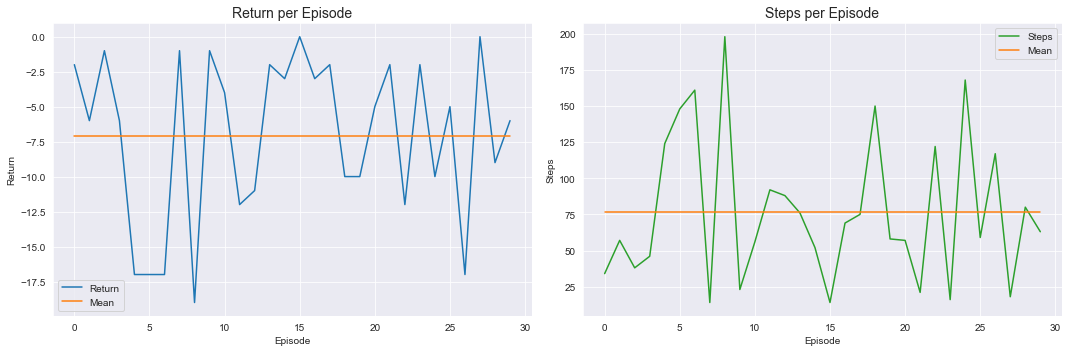

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

sns.set_style("darkgrid")
pallete = sns.color_palette()

mean_return = [np.mean(episode_returns) for i in range(num_episodes)]
mean_length = [np.mean(episode_length)  for i in range(num_episodes)]

fig = plt.figure(figsize=(15,5))

# Plot return per episode  
ax1 = fig.add_subplot(1,2,1)
ax1.plot(episode_returns, color=pallete[0])
ax1.plot(mean_return,     color=pallete[1])
ax1.legend(['Return','Mean'])
ax1.set_title("Return per Episode", fontsize=14)
plt.ylabel("Return")
plt.xlabel("Episode")

# Plot steps per episode
ax2 = fig.add_subplot(1,2,2)
ax2.plot(episode_length, color=pallete[2])
ax2.plot(mean_length,    color=pallete[1])
ax2.legend(['Steps','Mean'])
ax2.set_title("Steps per Episode", fontsize=14)
plt.ylabel("Steps")
plt.xlabel("Episode")

# Show the plot
plt.tight_layout()
plt.show()